<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
!pip install keras

In [3]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
# Corrected import for one_hot
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 108MB/s]


In [5]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [7]:
df = pd.DataFrame(data)
df

,dialog,start_time,end_time,bot_profile,user_profile,eval_score,profile_match,participant1_id,participant2_id
0,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 03:32:08.296000,2018-10-29 03:32:08.296000,[i like to talk but people have a hard time un...,"[i am a clean eater., my parents were both ver...",NaN,,"{'class': 'User', 'user_id': 'User 00172'}","{'class': 'Bot', 'user_id': 'Bot 004'}"
1,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 09:08:40,2018-10-29 09:12:32,"[my favorite singer is taylor swift., i love e...","[they are constantly on my back., i do not dri...",5.0,1,"{'class': 'User', 'user_id': 'User 00892'}","{'class': 'Bot', 'user_id': 'Bot 002'}"
2,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 12:12:12,2018-10-29 12:12:25,"[i'm pregnant with my first child., i read a b...","[i am a buddhist., i quit my job to pursue my ...",1.0,1,"{'class': 'User', 'user_id': 'User 00892'}","{'class': 'Bot', 'user_id': 'Bot 006'}"
3,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 12:23:56,2018-10-29 12:24:01,"[i like to ride horses., i help tend the field...","[i also like old school hip hop., i take dance...",1.0,1,"{'class': 'User', 'user_id': 'User 00892'}","{'class': 'Bot', 'user_id': 'Bot 006'}"
4,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 12:26:39,2018-10-29 12:33:51.064000,"[my wife spends all my money., i'm 40 years ol...","[i am in the third grade., mickey mouse is my ...",5.0,0,"{'class': 'User', 'user_id': 'User 00892'}","{'class': 'Bot', 'user_id': 'Bot 002'}"
...,...,...,...,...,...,...,...,...,...
1106,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-12-16 20:25:46,2018-12-16 20:26:34,"[i love to play pobox., i am a 12 year old gir...","[my family is continuously growing., i enjoy l...",1.0,0,"{'class': 'User', 'user_id': 'User 00321'}","{'class': 'Bot', 'user_id': 'Bot 011'}"
1107,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-12-16 20:27:17,2018-12-16 20:27:18.814000,"[i own two vintage mustangs., my favorite musi...","[spiderman is my favorite., if i am not cookin...",NaN,,"{'class': 'User', 'user_id': 'User 00321'}","{'class': 'Bot', 'user_id': 'Bot 002'}"
1108,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-12-17 13:08:23.897000,2018-12-17 13:08:42.941000,"[i'm retired and living the great life., i've ...","[i'm in an open polyamorous relationship., i a...",1.0,1,"{'class': 'User', 'user_id': 'User 00448'}","{'class': 'Bot', 'user_id': 'Bot 009'}"
1109,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-12-17 13:10:02.298000,2018-12-17 13:10:17.119000,"[i faint at the sight of blood., i've an inter...",[i am 19 and i cannot wait to move out 19 my p...,NaN,,"{'class': 'User', 'user_id': 'User 00448'}","{'class': 'Bot', 'user_id': 'Bot 009'}"


In [8]:
df.info()
df.sample(5)
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dialog           1111 non-null   object 
 1   start_time       1111 non-null   object 
 2   end_time         1111 non-null   object 
 3   bot_profile      1111 non-null   object 
 4   user_profile     1111 non-null   object 
 5   eval_score       593 non-null    float64
 6   profile_match    1111 non-null   object 
 7   participant1_id  1111 non-null   object 
 8   participant2_id  1111 non-null   object 
dtypes: float64(1), object(8)
memory usage: 78.2+ KB


,0
dialog,0
start_time,0
end_time,0
bot_profile,0
user_profile,0
eval_score,518
profile_match,0
participant1_id,0
participant2_id,0


In [9]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [11]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

In [12]:
def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

In [13]:
for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [17]:
data[1:2]

[{'dialog': [{'id': 0,
    'sender': 'participant1',
    'text': 'Hello!',
    'evaluation_score': None,
    'sender_class': 'Human'},
   {'id': 1,
    'sender': 'participant2',
    'text': 'Hi! How are you?',
    'evaluation_score': None,
    'sender_class': 'Bot'},
   {'id': 2,
    'sender': 'participant1',
    'text': 'Not bad! And You?',
    'evaluation_score': None,
    'sender_class': 'Human'},
   {'id': 3,
    'sender': 'participant2',
    'text': "I'm doing well. Just got engaged to my high school sweetheart.",
    'evaluation_score': None,
    'sender_class': 'Bot'},
   {'id': 4,
    'sender': 'participant1',
    'text': 'Wowowowow! Congratulations! Is she pretty?',
    'evaluation_score': None,
    'sender_class': 'Human'},
   {'id': 5,
    'sender': 'participant2',
    'text': "She 's pretty cute. She invited me to dinner tonight. 🙂",
    'evaluation_score': None,
    'sender_class': 'Bot'},
   {'id': 6,
    'sender': 'participant1',
    'text': 'Cool! Have a good time you b

In [19]:
input_sentences[10]

'i love disney movies '

In [20]:
output_sentences[10]

'what is your favorite  <eos>'

In [21]:
output_sentences_inputs[10]

'<sos> what is your favorite '

In [ ]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [26]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
# Vamos a necesitar un tokenizador para el idioma del bot

In [27]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.


# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)


word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [28]:
# tokenizador de la salida
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10


las sentencias de salida son más largas que la de la entrada, y lo mismo sucede con su vocabulario.

In [30]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 15
max_out_len = 15

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [31]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 15)
decoder_input_sequences shape: (6033, 15)


La última capa del modelo (softmax) necesita que los valores de salida del decoder (decoder_sequences) estén en formato oneHotEncoder.
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [32]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 15, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [33]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=515b060c-0e74-4073-8171-458e32931f23
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:10<00:00, 51.4MB/s]


In [ ]:
# En caso de que gdown de algún error de permisos intentar descargar los
# embeddings con curl:

#!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [34]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [35]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [36]:
# Crear la Embedding matrix de las secuencias
# ENTRADA

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 38


In [37]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(1799, 50)

In [38]:
# Crear la Embedding matrix de las secuencias
# SALIDA

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

out_words = min(MAX_VOCAB_SIZE, len(word2idx_outputs)) # vocab_size
out_embedding_matrix = np.zeros((out_words, embed_dim))
for word, i in word2idx_outputs.items():
    if i >= out_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        out_embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(out_embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 42


In [39]:
# Dimensión de los embeddings de la secuencia en inglés
out_embedding_matrix.shape

(1806, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [40]:
max_input_len

15

In [77]:

n_units = 256 #128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=True)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
#decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
#Reemplzo linea para usar mismo embeding que el imput
decoder_embedding_layer = Embedding(
    input_dim= out_words,   # Usar el número de palabras en el vocabulario de salida
    output_dim=embed_dim,  # Usar la misma dimensión de embedding que el encoder
    input_length=max_out_len, # tamaño máximo de la secuencia de salida
    weights=[out_embedding_matrix], # matrix de embeddings
    trainable=True # marcar como layer no entrenable
)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 15, 50)    │     89,950 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 15, 50)    │     90,300 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 256),     │    314,368 │ embedding_6[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 15, 256), │    314,368 │ embedding_7[0][0… │
│                     │ (None, 256),      │            │ lstm_6[0][1],     │
│                     │ (None, 256)]      │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 15, 1807)  │    464,399 │ lstm_7[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,273,385 (4.86 MB)

 Trainable params: 1,273,385 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

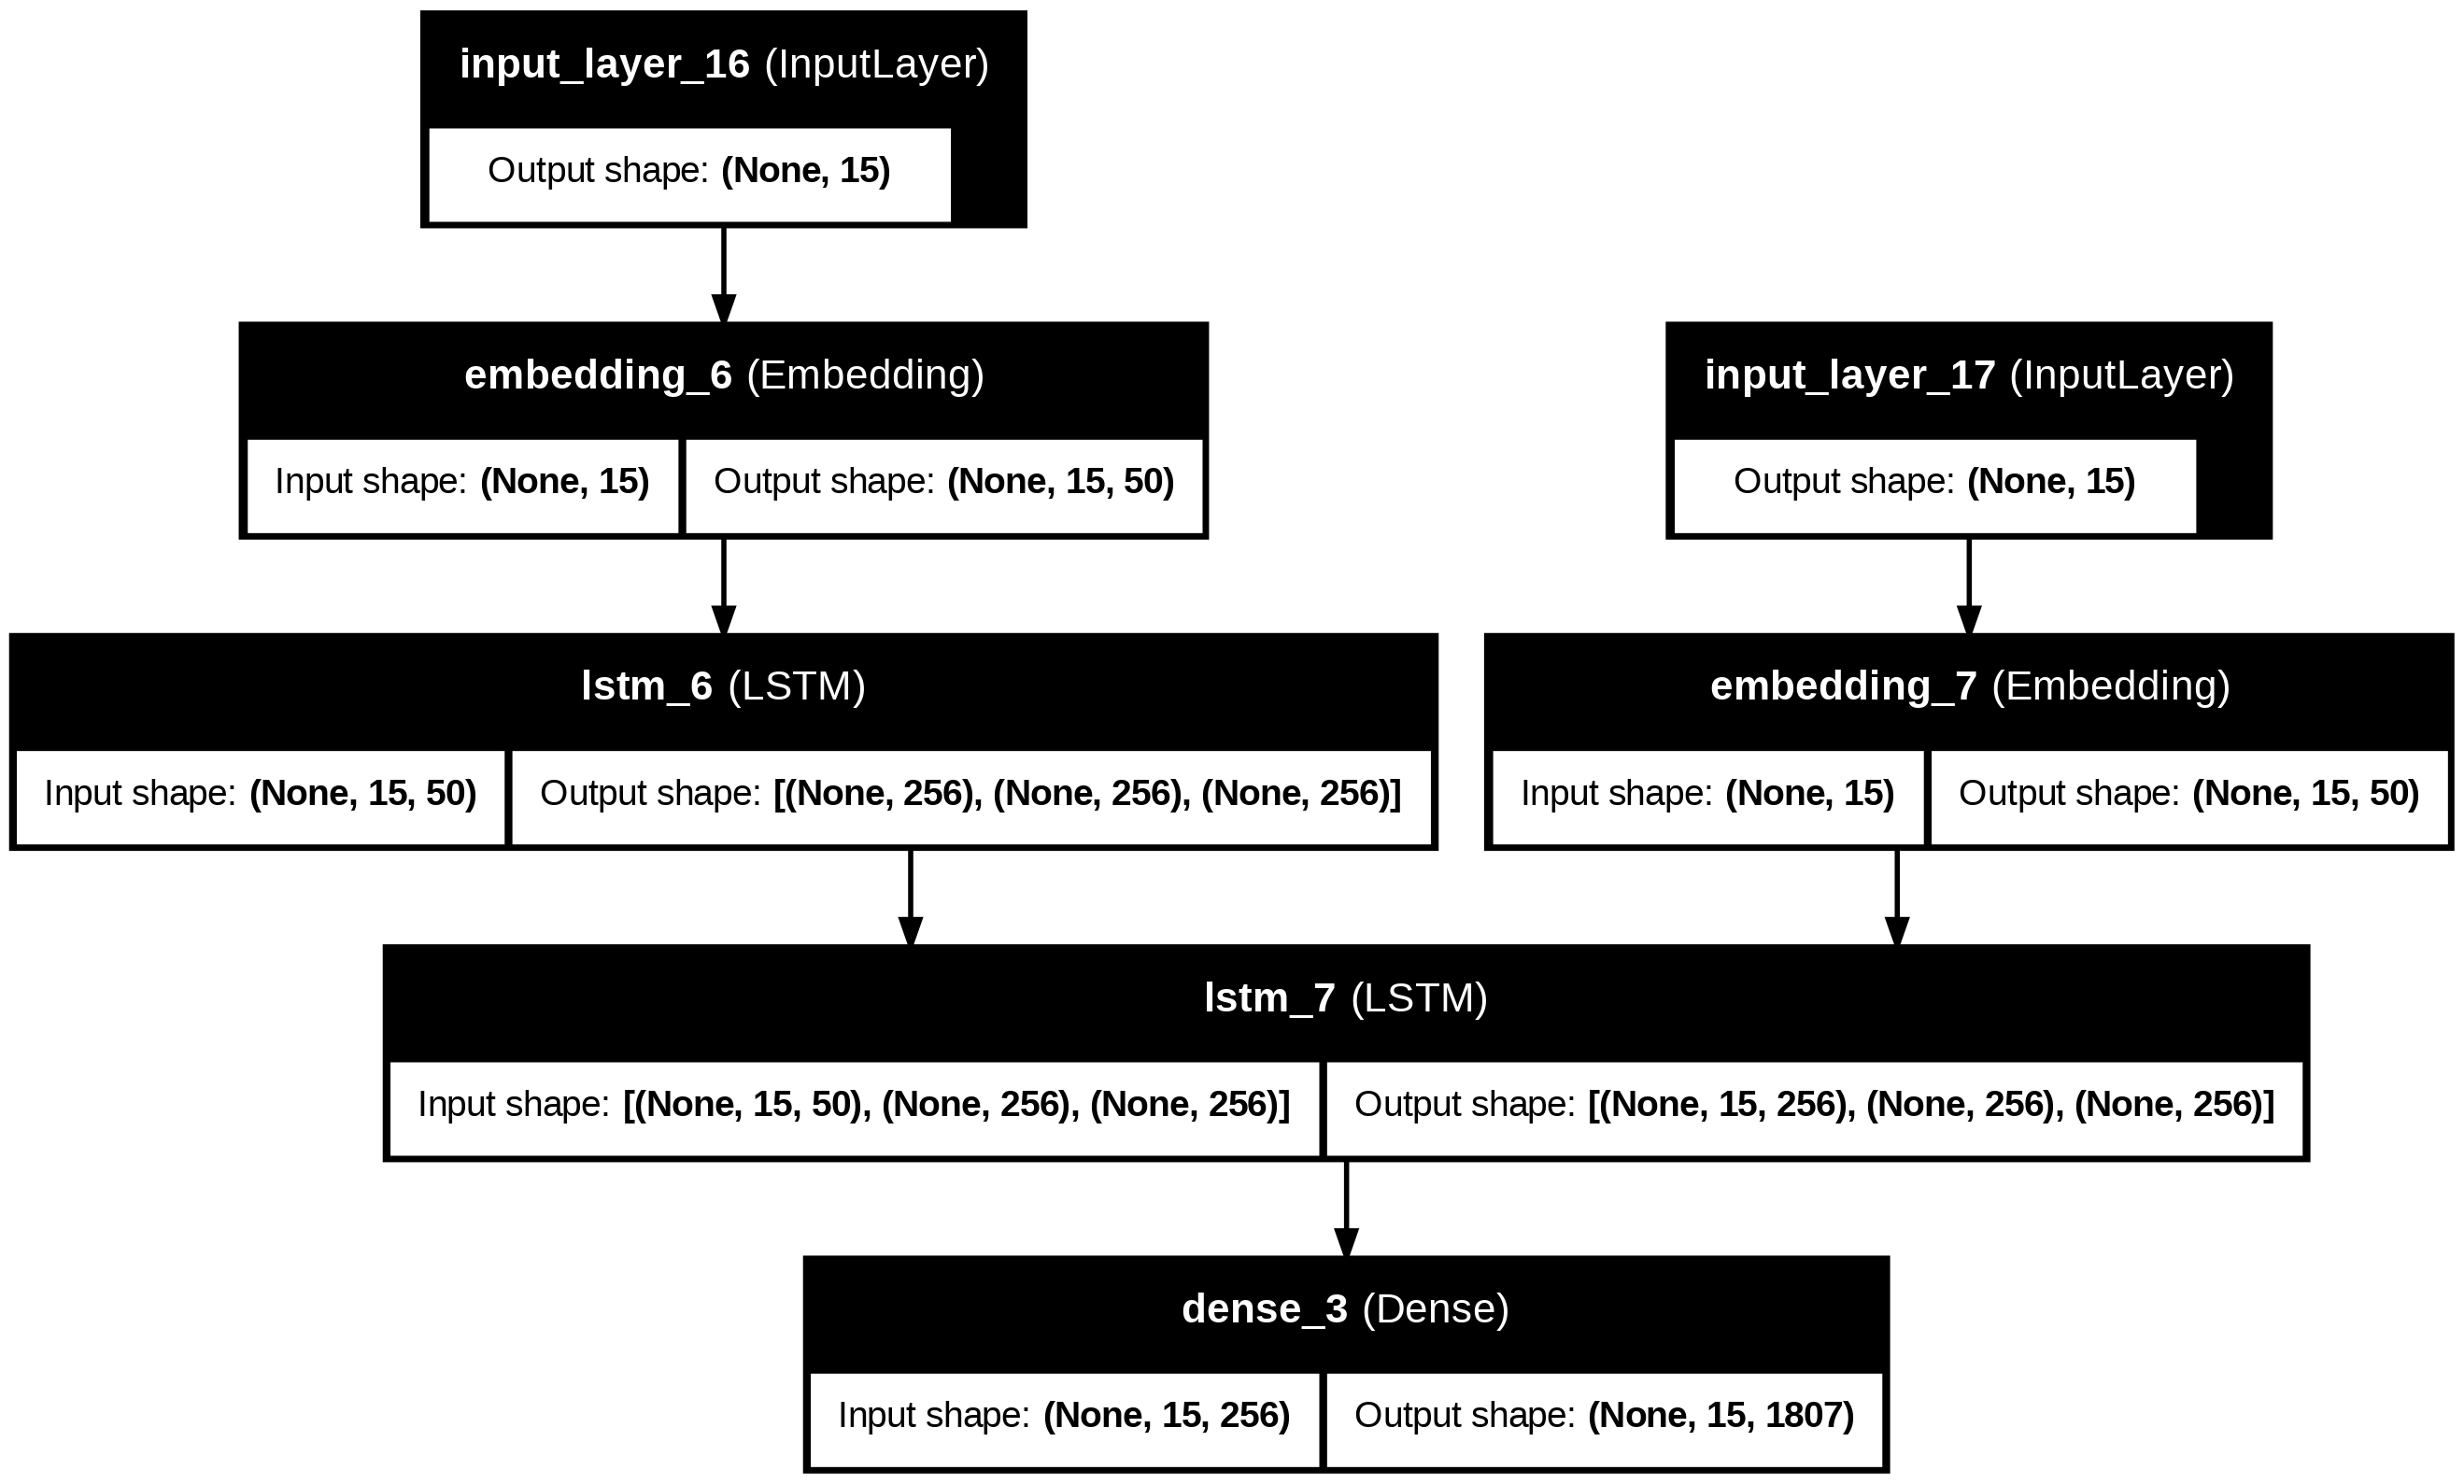

In [78]:
from keras.utils import plot_model
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

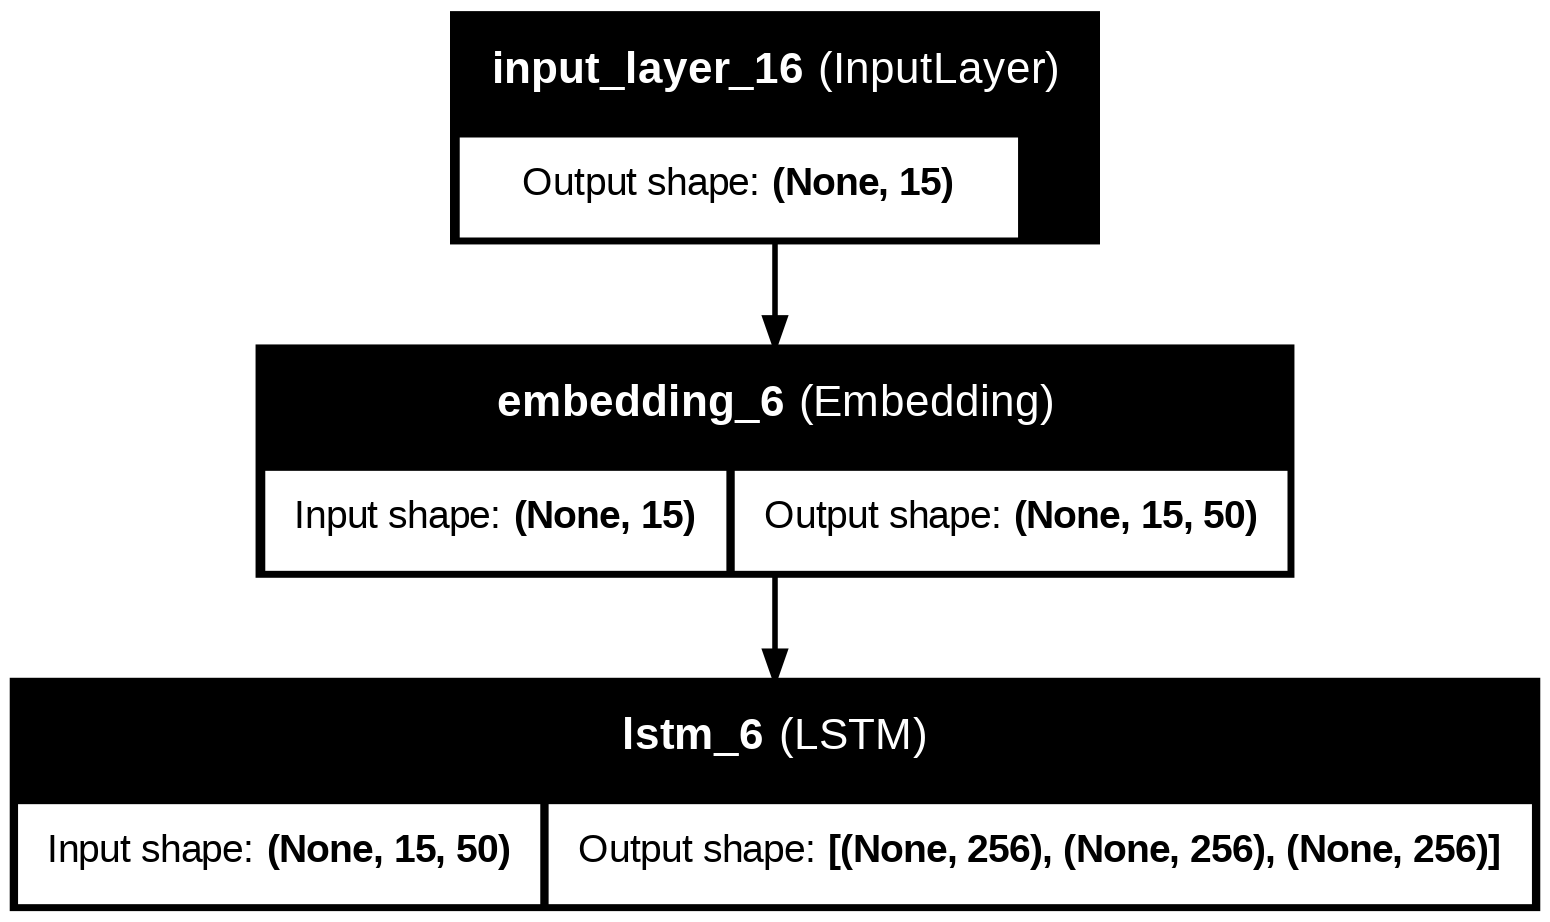

In [79]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

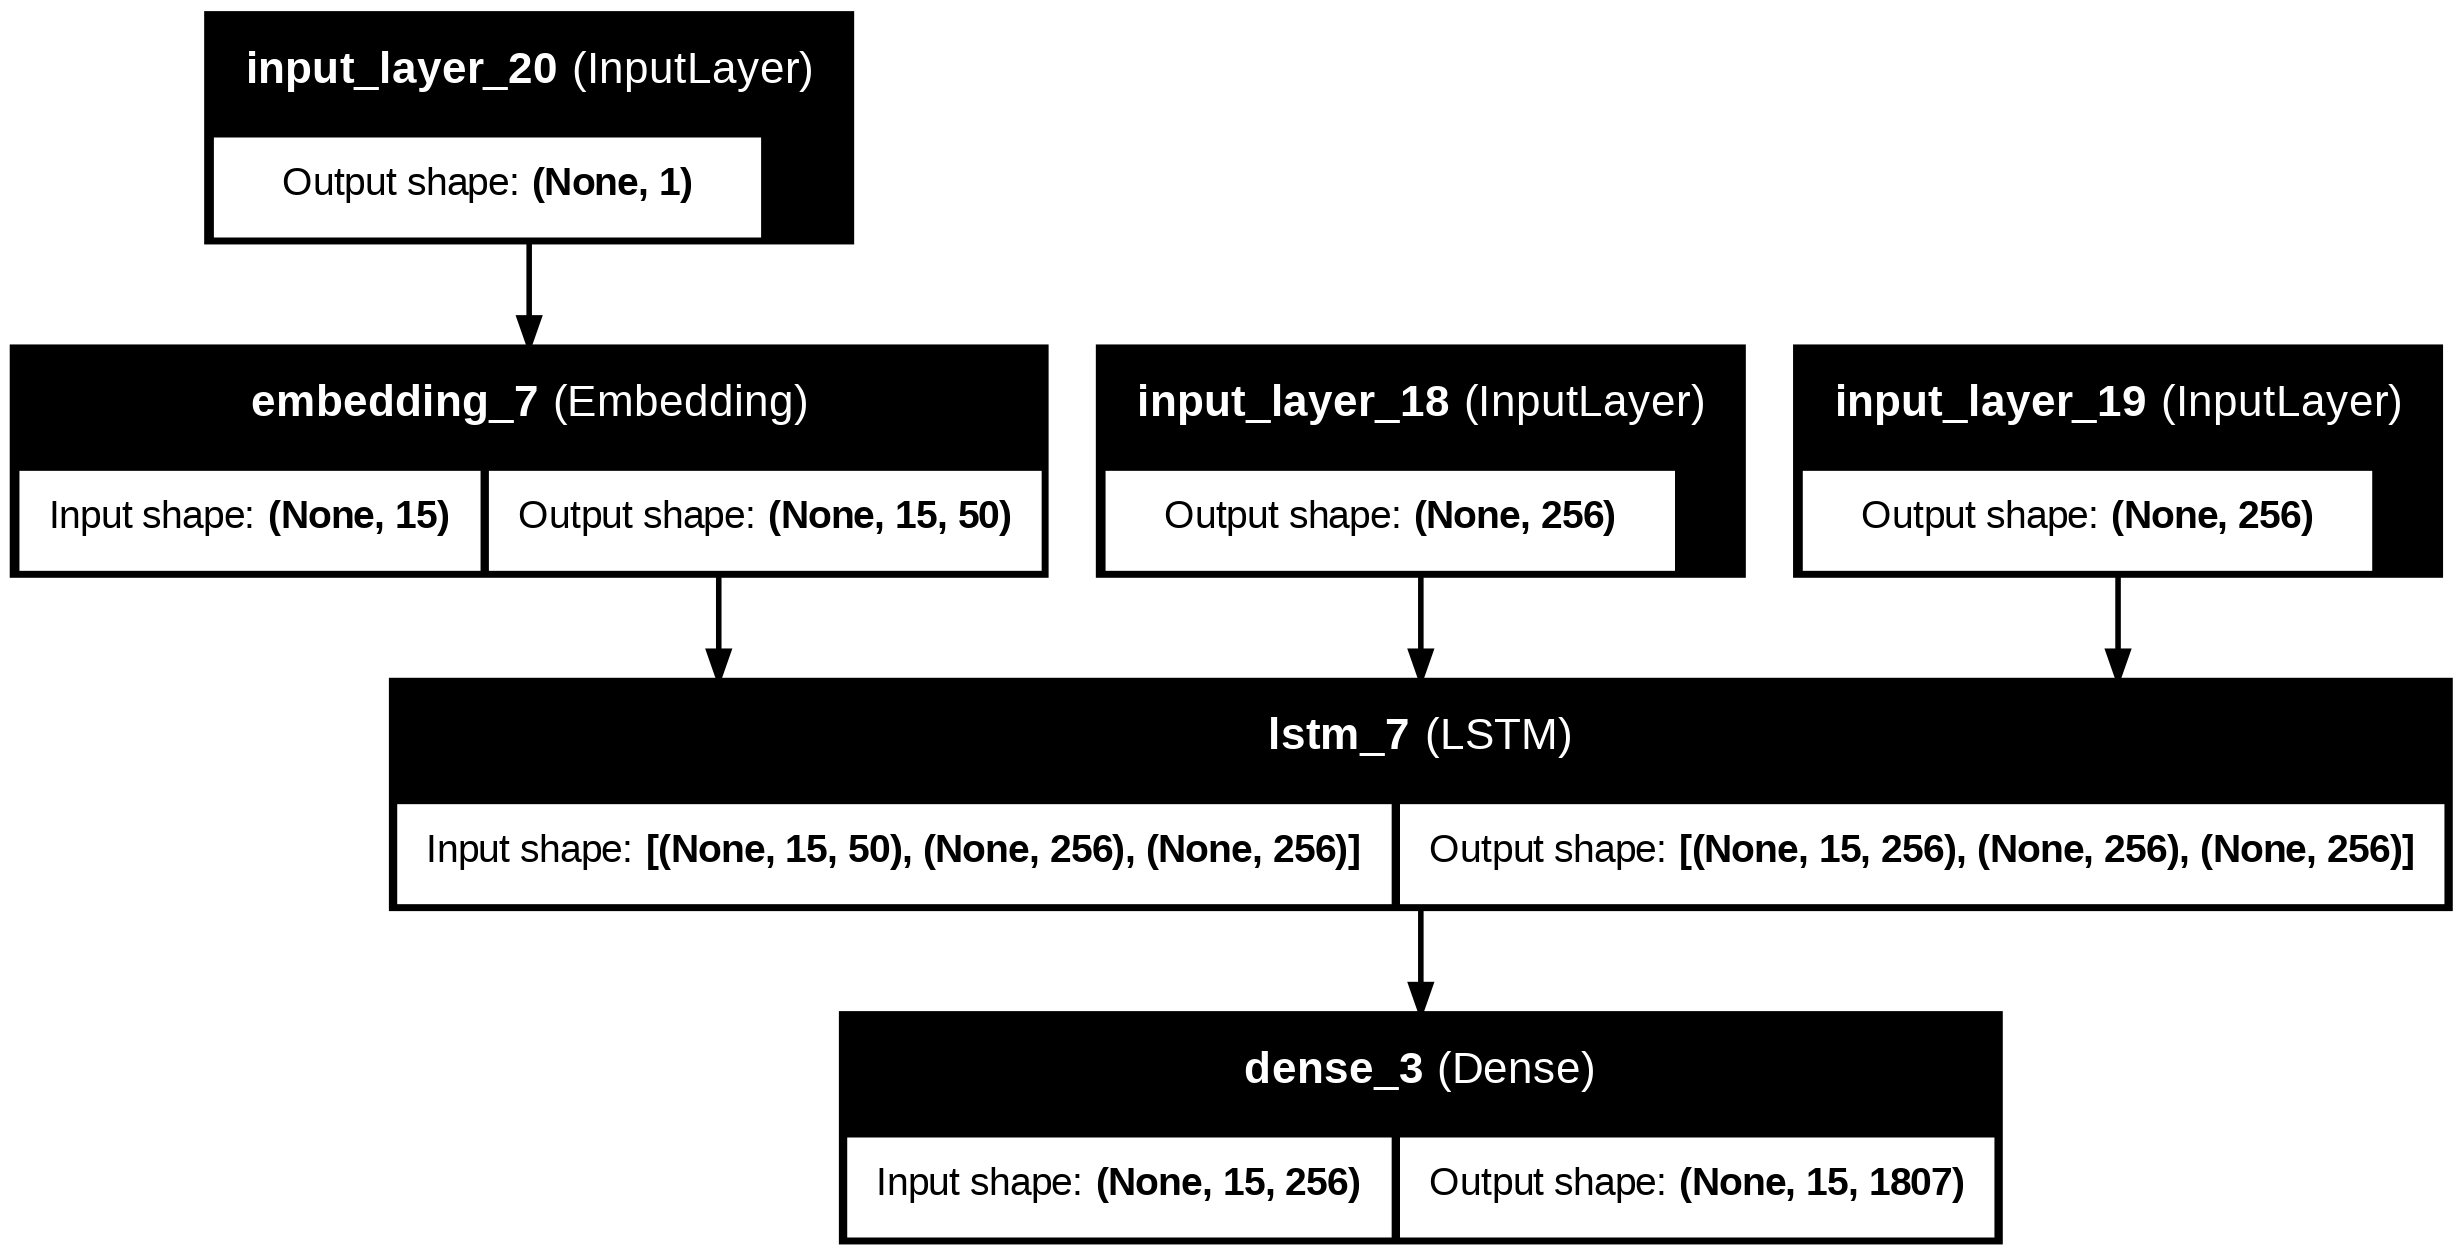

In [80]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [81]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15,
    validation_split=0.2)

Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6637 - loss: 2.7778 - val_accuracy: 0.7651 - val_loss: 1.4306
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7765 - loss: 1.2674 - val_accuracy: 0.7941 - val_loss: 1.2623
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8097 - loss: 1.0741 - val_accuracy: 0.8033 - val_loss: 1.1975
Epoch 4/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8215 - loss: 0.9838 - val_accuracy: 0.8077 - val_loss: 1.1558
Epoch 5/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8269 - loss: 0.9300 - val_accuracy: 0.8105 - val_loss: 1.1295
Epoch 6/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8342 - loss: 0.8835 - val_accuracy: 0.8134 - val_loss: 1.1158
Epoch 7/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8363 - loss: 0.8475 - val_accuracy: 0.8160 - val_loss: 1.0982
Epoch 8/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8404 - loss: 0.8136 - val_accu

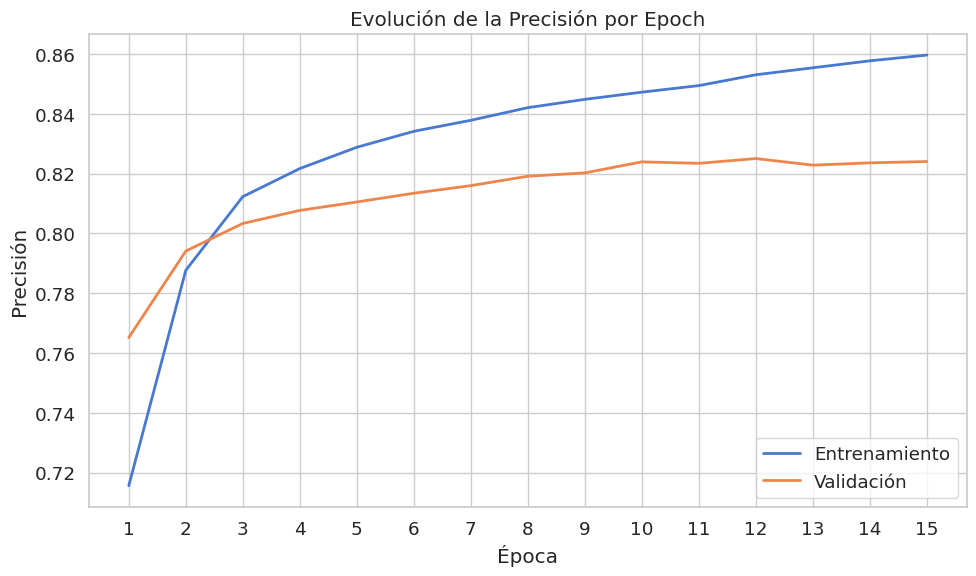

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo visual
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Rango de epochs
epoch_count = range(1, len(hist.history['accuracy']) + 1)

# Gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='Entrenamiento', linewidth=2)
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='Validación', linewidth=2)

# Etiquetas y título
plt.title('Evolución de la Precisión por Epoch')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.xticks(epoch_count)
plt.grid(True)
plt.tight_layout()
plt.show()


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [83]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [84]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [90]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
-
Input: how about you 
Response: i am fine


In [91]:
# Cantidad de muestras a generar
n_samples = 20
results = []

# Generar respuestas
for _ in range(n_samples):
    i = np.random.choice(len(input_sentences))
    input_text = input_sentences[i]
    input_seq = encoder_input_sequences[i:i+1]
    translation = translate_sentence(input_seq)

    results.append({
        'input': input_text,
        'predicted_output': translation
    })

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [92]:
# Crear DataFrame
df_responses = pd.DataFrame(results)
df_responses

,input,predicted_output
0,oh i see,what do you do for a living
1,who cares fuckk offf,what do you do for a living
2,am from india,i love to read
3,olakka puzhingi thinno,what do you do for a living
4,red n white,i like to go to the beach
5,i am going to be a doctor,oh i am a vegan
6,i love to read,i love to go to the beach
7,that s right,i love to read
8,ok see you later,i like to go to the beach
9,hi,hello how are you


In [93]:
input_test = "how are you"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: how are you
Representacion en vector de tokens de ids [10, 7, 2]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0 10  7  2]]
Input: how are you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Response: i am fine


### 6 - Conclusión Notebook: BOT + Traduccion

El modelo entrenado corresponde a una arquitectura clásica de tipo encoder-decoder basada en LSTM con embeddings entrenables. El encoder toma una secuencia de entrada de longitud máxima 15 y la transforma en un vector de estado, que luego es utilizado por el decoder para generar secuencias de salida también de longitud 15. Los embeddings utilizados tienen una dimensión de 50 y el vocabulario está compuesto por aproximadamente 1.800 palabras. La arquitectura cuenta con dos capas de embeddings (una para el encoder y otra para el decoder), dos capas LSTM con 256 unidades cada una, y una capa densa final que proyecta a la dimensión del vocabulario de salida. En total, el modelo tiene cerca de 1,27 millones de parámetros entrenables.

Durante el entrenamiento, se observó una evolución sostenida de la precisión en el conjunto de entrenamiento, alcanzando valores cercanos al 86%, mientras que en el conjunto de validación la precisión se estabilizó alrededor del 82%. Esto sugiere que el modelo logra aprender una representación útil de las relaciones input-output, pero también evidencia una posible brecha atribuible a cierta sobreajuste, especialmente hacia el final del proceso. El comportamiento del gráfico de precisión indica que el modelo sigue mejorando en entrenamiento incluso cuando la validación ya no presenta aumentos significativos.

En cuanto a los resultados semánticos, se observa que el modelo tiende a generar respuestas bien estructuradas y coherentes a nivel gramatical, pero con poca diversidad semántica. Muchas de las salidas generadas repiten frases como "what do you do for a living" o "i like to go to the beach", incluso cuando las entradas tienen poco o ningún vínculo temático con esas respuestas. Esto indica que el modelo ha memorizado respuestas frecuentes del dataset de entrenamiento y las reproduce de forma reiterada, lo cual reduce su capacidad para generar contenido informativo o contextualmente relevante. Aunque algunas respuestas son razonables en términos de tono conversacional ("i am fine", "i love to read"), la mayoría carecen de una correspondencia semántica precisa con las preguntas o afirmaciones de entrada. Esto limita su utilidad en tareas de generación natural de lenguaje o interacción dinámica.

En síntesis, la arquitectura es sólida y el entrenamiento fue exitoso en términos técnicos, pero el modelo evidencia limitaciones propias de los sistemas seq2seq sin atención ni embeddings contextuales, con una tendencia marcada a producir respuestas genéricas y repetitivas.